In [1]:
pdf= '../CovidWOBPDFs/1f95307518dbf35411b62adbfce7ed15_bijlage-2-bij-besluit-wob-verzoek-avondklok.pdf'


In [ ]:
%%time
%cd ../CovidWOBPDFs
L= !ls *.pdf
for f in L:
     !pdftohtml -q  -xml -hidden -fontfullname $f

/Users/admin/surfdrive/onderwijs/Afstudeerders/20212022/DaanKuypers/DocumentSplitting/CovidWOBPDFs


In [83]:
!ls -lh *.xml 

-rw-r--r--  1 admin  staff    22K Nov 28 15:06 0068ed0b40cca6270f857d2614cc63c0_besluit.xml
-rw-r--r--  1 admin  staff   7.8K Nov 28 15:06 0068ed0b40cca6270f857d2614cc63c0_document.xml
-rw-r--r--  1 admin  staff   225K Nov 28 15:06 0272cdb141e62321341591f0959794a2_derde-deelbesluit-aantal-aanwezigen-in-kerken.xml


In [13]:
!pdftohtml -q  -xml -hidden -fontfullname $pdf
!mv ../CovidWOBPDFs/1f95307518dbf35411b62adbfce7ed15_bijlage-2-bij-besluit-wob-verzoek-avondklok.xml test.xml

In [64]:
!head test.xml

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE pdf2xml SYSTEM "pdf2xml.dtd">

<pdf2xml producer="poppler" version="0.60.1">
<page number="1" position="absolute" top="0" left="0" height="1267" width="898">
	<fontspec id="0" size="37" family="Verdana-Bold" color="#000000"/>
	<fontspec id="1" size="10" family="Verdana" color="#000000"/>
	<fontspec id="2" size="7" family="Verdana-Bold" color="#000000"/>
	<fontspec id="3" size="7" family="Verdana" color="#000000"/>
	<fontspec id="4" size="13" family="Verdana" color="#000000"/>


# Handmatig splitsen

* hieronder mijn handmatige splitsing, op hert ruwe oog, met wat lezen.

#### Wat leren we?

1. Er zijn ook grote integers van 1-11 in het document geplakt. Maar bijv 5 mist, en ik had de overgang van 2 naar 3 niet door.  
2. Mails worden aan elkaar geplakt, en splitsen dus niet per pagina, allicht beter als apart geval beschouwen.
3. Lijkt toch wel heel goed te doen


### Voorstel aanpak "font vectors"

1. Maak een vector met een positie voor elk font type (font ID) dat in het doicument voorkomt.
    * ja,misschien moet je die font types wat uit elkaar halen/ juist bij elkaar groeperen, 
    * bijv bold en italics etc apart doen. Nou ja, kijk. Dat is ook weer "hacken" wat je niet wilt.
2. Allicht maak ook nog posities voor de font familiesm (Verdeana, Times, etc
3. Maak nu voor **elke pagina** in je document een vector waarin je 
    * het aantal karaktyers per font type opslaat
    * of
    * het aantal `text` blokken (xml elementen)
    * en waarom maak je niet beide vectoren.
4. *Nou is jouw doc splitting probleem een **clustering** probleem geworden in deze ruimte.*
    * je hebt per element (pagina) 2 reprsentaties
    * je weet dat je tiussen de 1 en "aantal paginas" veel clusters moet hebben
    * je weet dat clusters altijd opvolghend moeten zijn.
5. Los nu dit optimalisatieprobleem op.
6. Je hebt natuurlijk een similariteits maat nodig tussen de paginas.
    * speel wat met cosine, jaccard, weet ik wat....
7. Bekijk hoe ver je komt met deze aanpak, en geef een goede evaluatie.
8. Ik gok dat je B-cubed Precision en Recall wilt gebnruiken, maar bekijk dat goed en zorg daty je het snapt, of doe anders iets anders.
9. Annoteer (splits)  zelf een paar documenten echt eerlijk (of laat het iemand doen), en test hoe goed je het doet.
    * Mocht je nou denken, oo ik moet dit stukkie bewijs ook nog meennemen, maak dan eerst een aparte splitser daarvoor, en combineer ze dan op een goede manier. 


#### Fouten die je kunt verwachten

* Twee documenten vanuit dezelfde bron, dus met hetzelfde font, etc, achter elkaar worden aan elkaar geplakt. 
* Bijlages in een ander font worden losgekoppeld. (op zich niet erg voor een zoekmachine, als je maar onthoudt waar het vandaan kwam).

#### Andfere dingen

* leesrichting: landscape vs normaal
    * maar hier zit een voorbeeld waar het wisselt binnen hetzelfde document.

In [66]:
# handgecodeerde document splitsing, plus wat ik denk dat de "titel" is van elk losse document
# for deze $pdf dus
# Ik geef steeds alleen het pagina nummer van een nieuw document
hand={1:'oplegnota',
 3:' Scenario totale lockdown',
 8:'Scenario totale lockdown: juridische grondslagen',
 20:'nota',
 27:'Notitie avondklok 19 januari 2021 - 15.00u',
 32:'verslag',
 36: "Q&A's Avondklok",
 58:"Grapperhaus, F.BJ. - BD/AL", # diverse mails aan elkaar geplakt
 61:''  # appje???
}


In [67]:
from bs4 import BeautifulSoup
from lxml import etree
import  pandas as pd
%matplotlib inline

In [65]:
with open('test.xml') as f:
    tree = etree.parse(f)

# Probeersel 1

* Zouden heel veel nieuwe font specs een aanwijzing zijn voor een nieuw document?
* Lijkt van niet, het lijkt alsof pdftohtml die fonts zoveel mogelijk "vooraan" verzameld....
* In ieder geval zien we niet echt pieken bij doc grenzen.


dict_keys([1, 3, 8, 20, 27, 32, 36, 58, 61])


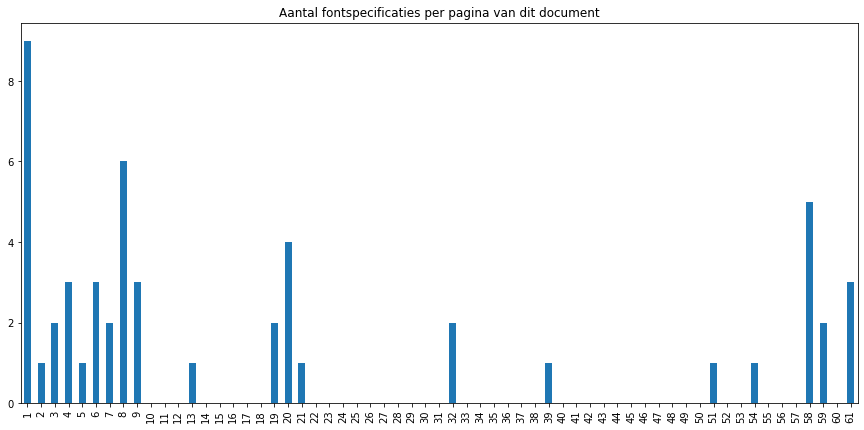

In [68]:
pages= tree.xpath('//page')

NrofFontSpecsPerPage=pd.Series({int(e.attrib['number']):len( e.xpath('fontspec')) for e in pages})

NrofFontSpecsPerPage.sort_index().plot(
    kind='bar',
    figsize=(15,7),
    title='Aantal fontspecificaties per pagina van dit document');

print(hand.keys())



# alle fonts op een rijtje

In [70]:
specs=  tree.xpath('//fontspec')
L=[  f.attrib for f in specs]

pd.concat([pd.DataFrame.from_dict(row,orient='index').T for row in L],ignore_index=True)

,id,size,family,color
0,0,37,Verdana-Bold,#000000
1,1,10,Verdana,#000000
2,2,7,Verdana-Bold,#000000
3,3,7,Verdana,#000000
4,4,13,Verdana,#000000
5,5,11,Tahoma,#000000
6,6,13,TimesNewRomanPS-ItalicMT,#000000
7,7,10,Verdana-Bold,#000000
8,8,3,Verdana,#000000
9,9,12,Verdana,#000000


In [69]:
# en hier het document in XML

!cat test.xml


<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE pdf2xml SYSTEM "pdf2xml.dtd">

<pdf2xml producer="poppler" version="0.60.1">
<page number="1" position="absolute" top="0" left="0" height="1267" width="898">
	<fontspec id="0" size="37" family="Verdana-Bold" color="#000000"/>
	<fontspec id="1" size="10" family="Verdana" color="#000000"/>
	<fontspec id="2" size="7" family="Verdana-Bold" color="#000000"/>
	<fontspec id="3" size="7" family="Verdana" color="#000000"/>
	<fontspec id="4" size="13" family="Verdana" color="#000000"/>
	<fontspec id="5" size="11" family="Tahoma" color="#000000"/>
	<fontspec id="6" size="13" family="TimesNewRomanPS-ItalicMT" color="#000000"/>
	<fontspec id="7" size="10" family="Verdana-Bold" color="#000000"/>
	<fontspec id="8" size="3" family="Verdana" color="#000000"/>
<image top="0" left="0" width="899" height="1267" src="../CovidWOBPDFs/1f95307518dbf35411b62adbfce7ed15_bijlage-2-bij-besluit-wob-verzoek-avondklok-1_1.jpg"/>
<text top="405" left="132" width="194" 